Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to perform contamination removal of X01 from GRB 190829A in epochs 201909 and 201910 for both G102 and G141. G102 at epoch 201910 is the most severely contaminated among these.

# Previously
This is a continuation of 20200819, where we ended with unfinished ApPhot due to several issues (see summary). After exploring INS training modules and developing to_phot() earlier on 20200820, we are ready to continue with this task.

# What's in this file?
A template for HSTPHOT pipeline.

# Task
ApPhot will be reworked as a wrapper of aperture_photometry by photutils. It will take only a 2D image, center, and aperture radius. Error will be computed using the image for its poisson error using calc_total_error with an option to specify additional background error component. (However, in our pipeline, we will not use this option). 

Note that we do not include aperture correction with ApPhot.

Output will ...

# What to do?
We will develop the pipeline, and test again a known standard star such as GD153. We will use proposal ID 11552.

# Resources
- HSTPHOT package (pip install hstphot)
- to_phot function from 02_pysynphot.ipynb


In [1]:
import pysynphot as S

def to_phot(spectrum_wave,spectrum_flux,obsbandpass,
            waveunits='angstrom',fluxunits='flam',name='None',keepneg=False,
            force=None
           ):
    """
    to_phot is a convenient function to compute photometric equivalence given a spectral profile. This routine uses pysynphot.
    - pysynphot.ArraySpectrum(spectrum_wave,spectrum_flux,waveunits,fluxunits,name,keepneg)
    - pysynphot.ObsBandpass(obsbandpass)
      - obsbandpass = 'wfc3,ir,f140w' for example. Note that all lower cases.
    - pysynphot.Observation(ArraySpectrum, ObsBandpass, force)
      - force can be None, 'extrap', or 'taper.' Note: if keepneg = True and there is a negative element in the ArraySpectrum, this will crash.
    The routine returns pysynphot.Observation.
    Use return.efflam() for effective wavelength.
    Use return.effstim('flam') for effective flam.
    """
    spc = S.ArraySpectrum(spectrum_wave,spectrum_flux,waveunits,fluxunits,name,keepneg)
    obs = S.Observation(spc,S.ObsBandpass(obsbandpass),force=force)
    return obs


In [2]:
from hstphot.read_ds9region import read_ds9region
from hstphot.container import Container
from hstphot.cutout2d import Cutout2d
from hstphot.objectmask import ObjectMask
from hstphot.background import Background
from hstphot.apphot import ApPhot
from hstphot.phot2abmag import Phot2ABmag
from hstphot.mag2flux import mag2flux
from hstphot.to_fullframe import to_fullframe
from hstphot.show_source import show_source
from hstphot.show_sum1d import show_sum1d
from mag2flux.mag2flux import mag2flux
from drizzlepac.astrodrizzle import AstroDrizzle
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,copy

sourcename = 'GD153'
xyd_adjust = np.array([(1.,1.),(0.,1.),(0.,0.)])


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [3]:
tp = '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST'
t = glob.glob(tp + '/*/*flt.fits')
filelist = []
for i,ii in enumerate(t):
    th = fits.open(ii)[0].header
#     print('{0} {1} {2} {3}'.format(i,th['ROOTNAME'],th['FILTER'],th['SUBARRAY']))
    if th['FILTER'] in {'F098M'}:
        filelist.append((th['ROOTNAME'],th['FILTER'],ii))
filelist


[('iab901eqq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901eqq/iab901eqq_flt.fits'),
 ('iab901eiq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901eiq/iab901eiq_flt.fits'),
 ('iab9a1ewq',
  'F098M',
  '/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab9a1ewq/iab9a1ewq_flt.fits')]

# 1. drzlist, and other hstphot outputs
Take from 20200819.


In [4]:
t = []
for i in filelist:
    string = '../20200819/{0}_drz.fits'.format(i[0])
    t.append((i[0],i[1],string))
drzlist = copy.deepcopy(t)
drzlist


[('iab901eqq', 'F098M', '../20200819/iab901eqq_drz.fits'),
 ('iab901eiq', 'F098M', '../20200819/iab901eiq_drz.fits'),
 ('iab9a1ewq', 'F098M', '../20200819/iab9a1ewq_drz.fits')]

In [5]:
cutoutlist = {}
for ii,i in enumerate(drzlist):
    t1 = '../20200819/{0}/{0}_cutout.fits'.format(i[0])
    t2 = '../20200819/{0}/{0}_mask.fits'.format(i[0])
    t3 = '../20200819/{0}/{0}_cutbkg.fits'.format(i[0])
    t4 = '../20200819/{0}/{0}_bbcorner.csv'.format(i[0])
    cutoutlist[i[0]] = (t1,t2,t3,t4)
cutoutlist


{'iab901eqq': ('../20200819/iab901eqq/iab901eqq_cutout.fits',
  '../20200819/iab901eqq/iab901eqq_mask.fits',
  '../20200819/iab901eqq/iab901eqq_cutbkg.fits',
  '../20200819/iab901eqq/iab901eqq_bbcorner.csv'),
 'iab901eiq': ('../20200819/iab901eiq/iab901eiq_cutout.fits',
  '../20200819/iab901eiq/iab901eiq_mask.fits',
  '../20200819/iab901eiq/iab901eiq_cutbkg.fits',
  '../20200819/iab901eiq/iab901eiq_bbcorner.csv'),
 'iab9a1ewq': ('../20200819/iab9a1ewq/iab9a1ewq_cutout.fits',
  '../20200819/iab9a1ewq/iab9a1ewq_mask.fits',
  '../20200819/iab9a1ewq/iab9a1ewq_cutbkg.fits',
  '../20200819/iab9a1ewq/iab9a1ewq_bbcorner.csv')}

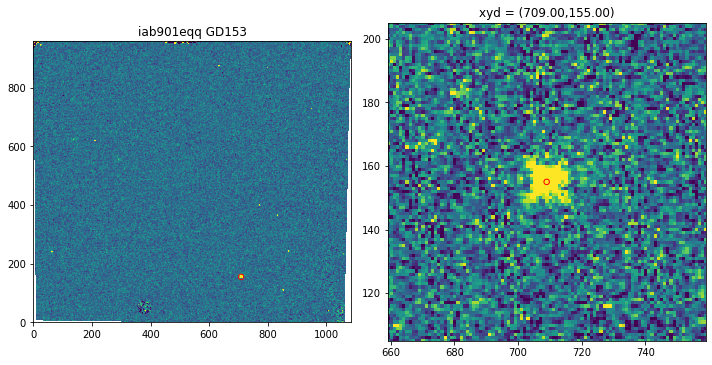

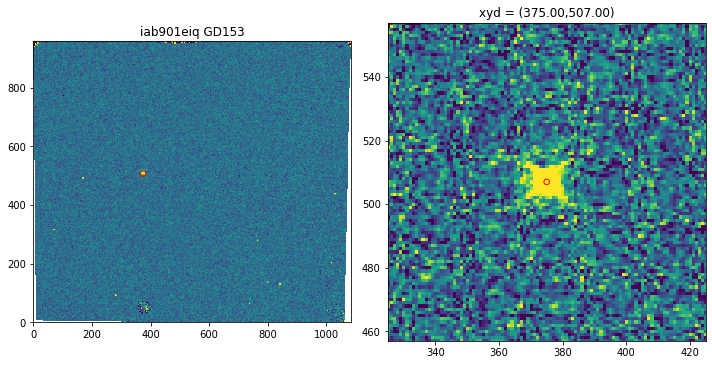

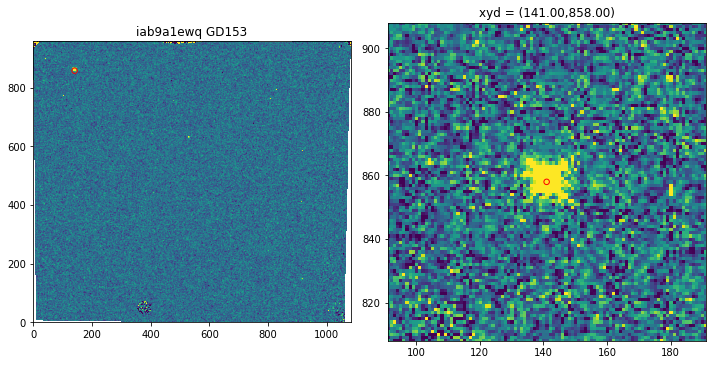

In [6]:
##########
# use show_source
##########
for ii,i in enumerate(drzlist):
    dfile = (i[2],1)
    xyd = pd.read_csv(cutoutlist[i[0]][3]).xyd
    title = '{0} {1}'.format(i[0],sourcename)
    show_source(dfile,xyd,title,save=False)
    

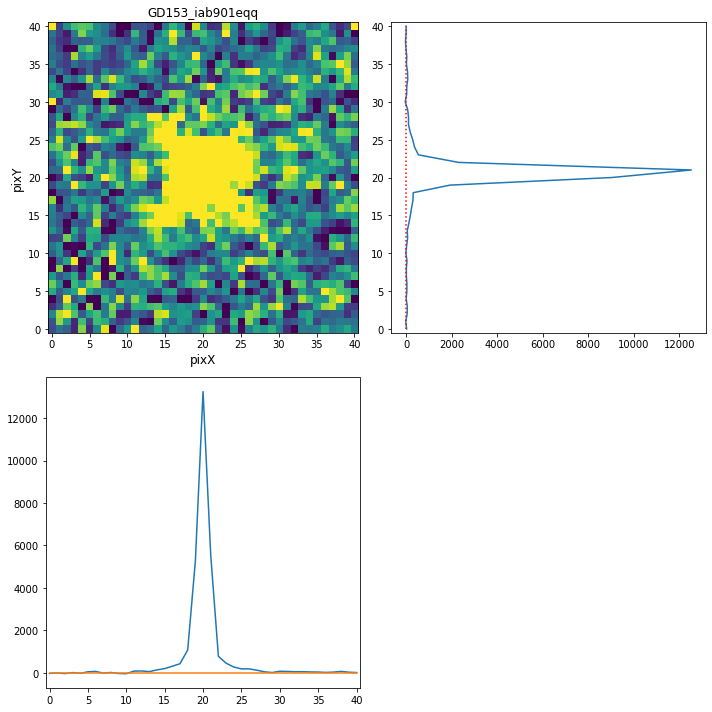

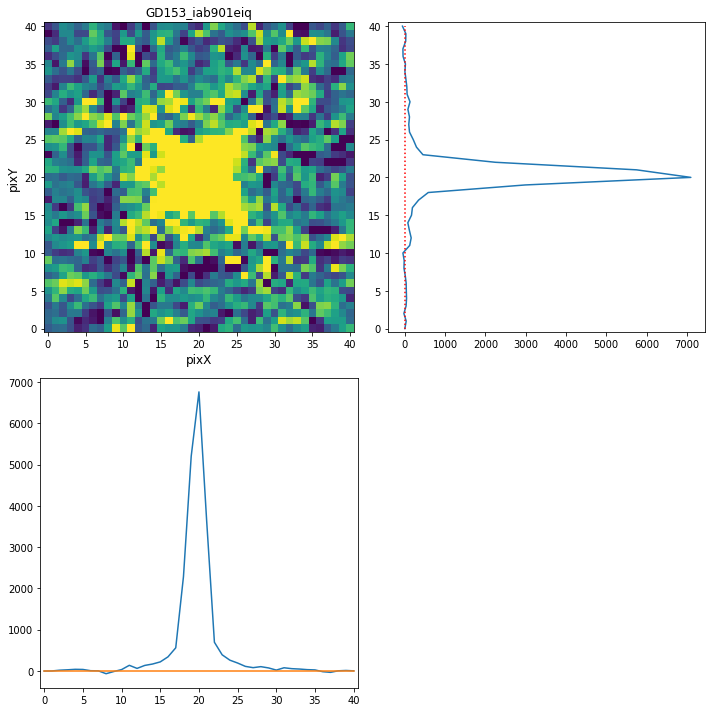

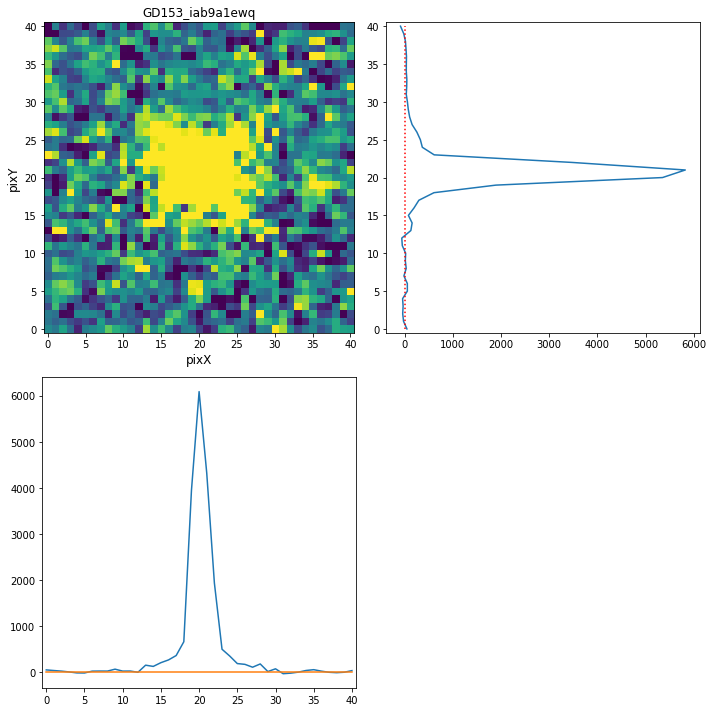

In [7]:
for ii,i in enumerate(drzlist):
    gdata = fits.open(cutoutlist[i[0]][0])[1].data
    objname = '{0}_{1}'.format(sourcename,i[0])
    show_sum1d(gdata,objname,save=False)


# 2. ApPhot

In [8]:
# # Kornpob Bhirombhakdi
# # kbhirombhakdi@stsci.edu

# from photutils import CircularAperture
# from photutils import aperture_photometry
# from photutils.utils import calc_total_error
# import pandas as pd

# class ApPhot:
#     """
#     ApPhot is a class to perform circular aperture photometry. The code uses photutils, and follows closely to its instruction (https://photutils.readthedocs.io/en/stable/aperture.html).
#     - aperture unit must be in pixel.
#     - data = 2D image to be measured
#     - ebkg, effgain = error from additional component such as background, and effective gain.
#       - These values are used in computing total errors by using photutils.utils.calc_total_error.
#       - If unknown, a user can set ebkg = 0 and effgain = 1.
#     - center = (pixX,pixY) of centroid
#     - aperture_radius = aperture radius in pixel unit
#     Use self.compute() method after instantiation to perform the photometry.
#     - self.apphot contains the outputs from computation including
#       - apphot['error'] = total error. If ebkg = 0, this is equivalent to poisson error from the data scaled by effective gain.
#       - apphot['aperture'] = photutils.CircularAperture object given center and aperture_radius
#       - apphot['phot_table'] = photometry as the main output for this routine.
#     Use self.save(container) method to save output to ./savefolder/saveprefix_apphot.csv given Container.
#     """
#     def __init__(self,data,ebkg,effgain,center,aperture_radius):
#         self.data = data
#         self.ebkg = ebkg
#         self.effgain = effgain
#         self.center = center
#         self.aperture_radius = aperture_radius
#     def compute(self):
#         error = calc_total_error(self.data,self.ebkg,self.effgain)
#         aperture = CircularAperture(self.center,r=self.aperture_radius)
#         phot_table = aperture_photometry(self.data,aperture,error=error)
#         self.apphot = {'error':error,'aperture':aperture,'phot_table':phot_table}
#     def save(self,container=None):
#         if container is None:
#             raise ValueError('container must be specified to save.')
#         sf = container.data['savefolder']
#         sp = container.data['saveprefix']
#         string = './{0}/{1}_apphot.csv'.format(sf,sp)
#         t = {'aperture_radius':self.aperture_radius,
#              'aperture_sum':self.apphot['phot_table']['aperture_sum'],
#              'aperture_sum_err':self.apphot['phot_table']['aperture_sum_err']
#             }
#         pd.DataFrame(t).to_csv(string)
#         print('Save {0}'.format(string))
        

In [9]:
aperture_radius = 5
apphot = []
for ii,i in enumerate(drzlist):
    th = fits.open(i[2])[0].header
    effgain = th['EXPTIME']
    data = fits.open(cutoutlist[i[0]][0])[1].data
    ebkg = 0.
    bbcorner = pd.read_csv(cutoutlist[i[0]][3])
    center = bbcorner.xyd.values - np.array([bbcorner.bbx[0],bbcorner.bby[0]])
    t = ApPhot(data,ebkg,effgain,center,aperture_radius)
    t.compute()
    tc = Container(i[0],i[0],'pdf',False)
    t.save(container=tc)
    apphot.append(t.apphot)


Save ./iab901eqq/iab901eqq_apphot.csv
Save ./iab901eiq/iab901eiq_apphot.csv
Save ./iab9a1ewq/iab9a1ewq_apphot.csv


# 3. Phot2Mag

In [10]:
# # Kornpob Bhirombhakdi
# # kbhirombhakdi@stsci.edu

# from hstphot.photapcorr import PhotApCorr
# import numpy as np
# import pandas as pd

# class Phot2ABmag:
#     """
#     Phot2ABmag is a class to convert from photometric counts/sec (cps) to AB magnitude.
#     The code will grab aperture correction from a table specified by instrument, filterobs, and aperture_radius. The table is recorded in hstphot.photapcorr.PhotApCorr class.
#     - self.available_instrument and self.available_filterobs after instantiation with any mock parameters will provide available support.
#     - aperture_radius must be in pixel.
#     Use self.compute() method to compute AB magnitude and its error:
#     - ABmag = -2.5 * np.log10(cps / apcorr) + zp
#     - emag = 2.5 * np.sqrt(error**2) / (cps * np.log(10.))
#     - self.mag = (ABmag,emag)
#     - self.wavelength and self.zp provide the effective wavelength and zeropoint.
#     - self.apcorr provides aperture correction value.
#     Use self.save(container) to save output to ./savefolder/saveprefix_mag.csv given Container.
#     """
#     def __init__(self,instrument,filterobs,aperture_radius,cps,error):
#         self.instrument = instrument
#         self.filterobs = filterobs
#         self.aperture_radius = aperture_radius
#         self.cps = cps
#         self.error = error
#         self.available_instrument = self._available_instrument()
#         self.available_filterobs = self._available_filterobs()
#     def compute(self):
#         t = PhotApCorr(self.instrument)
#         self.wavelength,self.zp = t.table['ZP'][self.filterobs]
#         self.scale = t.table['scale']        
#         apsize = self.aperture_radius * self.scale
#         t = PhotApCorr(instrument,apsize,self.wavelength)
#         t.compute()
#         self.apcorr = t.apcorr[0]
#         tm = -2.5 * np.log10(self.cps / self.apcorr) + self.zp
#         tem = 2.5 * np.sqrt(self.error**2) / (self.cps * np.log(10.))
#         self.mag = (tm,tem)
#     def save(self,container=None):
#         if container is None:
#             raise ValueError('container must be specified to save.')
#         sfolder = container.data['savefolder']
#         sprefix = container.data['saveprefix']
#         string = './{0}/{1}_mag.csv'.format(sfolder,sprefix)
#         t = {'wavelength':self.wavelength,'ABmag':self.mag[0],'emag':self.mag[1],'zp':self.zp}
#         pd.DataFrame(t,index=[0]).to_csv(string)
#         print('Save {0}'.format(string))
#     def _available_instrument(self):
#         return PhotApCorr().available_instrument
#     def _available_filterobs(self):
#         try:
#             t = PhotApCorr(self.instrument).table['ZP'].keys()
#             return t
#         except:
#             string = 'instrument must be specified when instantiate. Use self.available_instrument to see support.'
#             return string
        

In [11]:
instrument = 'HST-WFC3-IR'
for ii,i in enumerate(drzlist):
    filterobs = i[1]
    t = pd.read_csv('./{0}/{0}_apphot.csv'.format(i[0]))
    aperture_radius = t.aperture_radius[0]
    cps = t.aperture_sum[0]
    error = t.aperture_sum_err[0]
    t = Phot2ABmag(instrument,filterobs,aperture_radius,cps,error)
    t.compute()
    tc = Container(i[0],i[0],'pdf',False)
    t.save(container=tc)
    

Save ./iab901eqq/iab901eqq_mag.csv
Save ./iab901eiq/iab901eiq_mag.csv
Save ./iab9a1ewq/iab9a1ewq_mag.csv


# Check with pysynphot

In [12]:
filepath = '/Users/kbhirombhakdi/_work/_calib_files/PYSYN_CDBS/calspec/gd153_mod_010.fits'
t = fits.open(filepath)
spectrum_wave = t[1].data.WAVELENGTH.copy()
spectrum_flux = t[1].data.FLUX.copy()
obsbandpass = 'wfc3,ir,f098m'
gd153_f098m = to_phot(spectrum_wave,spectrum_flux,obsbandpass)


In [13]:
gd153_f098m.efflam(),gd153_f098m.effstim('flam')

(9805.743886581551, 1.7510253396546298e-15)

In [14]:
for ii,i in enumerate(drzlist):
    t = pd.read_csv('./{0}/{0}_mag.csv'.format(i[0]))
    t = mag2flux(t.ABmag[0],t.emag[0],t.wavelength[0])
    print(i[0], t)

iab901eqq (1.764280458240684e-15, 4.463196800654188e-18)
iab901eiq (1.2851006306014753e-15, 3.809232615964547e-18)
iab9a1ewq (1.1709997299998832e-15, 3.636584127216123e-18)


# Summary
We completed the initial development of HSTPHOT 1.2.0, and this Notebook demonstrated how to use it.

We noted that the flams we got from three images of GD153 F098M are incorrect. We will investigate this issue in the next attempt. Suspects include:
- bad drizzling: we will try reducing with flt, and see whether the outputs are more stable.
- error due to location: the three images have GD153 at three locations: bottom right, center, top left. Variation across CCD chip is acknowledge. However, we do not have information at this moment whether it can vary with this large amount.

We noted that this problem does not entail from:
- background subtraction since we did not perform that step here,
- aperture size since we tested with various aperture sizes

Another thing to try is to test with several other datasets.
